In [1]:
# ============================================================
# PulseDB / MIMIC single-subject (p043774) — time-aware protocol sweep
# CLEANED:
#   - Use PPG_F only (already per-segment min-max 0~1) => NO extra bandpass / NO extra input min-max
#   - Keep 중요 로직(시간 split + block gap + time gap + block-test) 그대로
# FIXED (critical):
#   - Label scaling is TRAIN-ONLY per fold (NO future leakage)
# ADDED:
#   - Report MAE + SD (std of signed error) in mmHg for SBP/DBP
# ============================================================

import time
import random
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
import pandas as pd

# ==========================================
# [0] 실험 환경 설정
# ==========================================
MAT_FILE = "/content/drive/MyDrive/Colab Notebooks/PusleDB/p043774.mat"
SEGMENT_LIMIT = None          # None = all
PAD_LEN = 200
SEC_PER_SEGMENT = 10.0

BATCH_SIZE = 32
EPOCHS = 60
LR = 1e-3
WEIGHT_DECAY = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Using Device: {DEVICE}")

# ==========================================
# [1] Re-sample + Prior feature
# ==========================================
def cubic_resample(ppg, target_len=PAD_LEN):
    """Cubic spline interpolation (fallback to linear)"""
    x_old = np.linspace(0, 1, len(ppg))
    x_new = np.linspace(0, 1, target_len)
    if len(ppg) < 4:
        return np.interp(x_new, x_old, ppg).astype(np.float32)
    try:
        f = interp1d(x_old, ppg, kind="cubic", bounds_error=False, fill_value="extrapolate")
        return f(x_new).astype(np.float32)
    except Exception:
        return np.interp(x_new, x_old, ppg).astype(np.float32)

def extract_multiscale_morph_features(ppg_01):
    """
    Multi-scale Morphological Feature Extraction (44 dims)
    - PPG_F already 0~1 per segment => use directly
    """
    scales = [100, 150, 200, 250]
    all_features = []

    for scale in scales:
        x = cubic_resample(ppg_01, scale)

        peak_idx = int(np.argmax(x))
        end_idx = scale - 1

        vp = float(x[peak_idx])
        vt = float(x[end_idx])
        dv = vp - vt
        vm = float(np.mean(x))
        std_val = float(np.std(x))

        tvp = peak_idx / scale

        diff = np.diff(x)
        kmax = float(np.max(diff)) if len(diff) > 0 else 0.0
        tkmax = (int(np.argmax(diff)) / scale) if len(diff) > 0 else 0.0

        amax = float(trapezoid(x[:peak_idx])) if peak_idx > 0 else 0.0

        centered = x - vm
        skew_approx = float(np.mean(centered**3) / (std_val**3)) if std_val > 0 else 0.0
        kurt_approx = float(np.mean(centered**4) / (std_val**4)) if std_val > 0 else 0.0

        all_features.extend([vp, vt, dv, vm, kmax, tkmax, amax, std_val, tvp, skew_approx, kurt_approx])

    return np.array(all_features, dtype=np.float32)

# ==========================================
# [2] 데이터 로딩 (PPG_F only)
# ==========================================
def load_data_from_mat(mat_path, segment_limit=None):
    segments, priors, targets = [], [], []
    with h5py.File(mat_path, "r") as f:
        refs = f["Subj_Wins"]["PPG_F"][0]
        sbps = f["Subj_Wins"]["SegSBP"][0]
        dbps = f["Subj_Wins"]["SegDBP"][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)
        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)   # (1250,) already 0~1
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            priors.append(extract_multiscale_morph_features(ppg))
            targets.append([sbp, dbp])

            if i % 1000 == 0:
                print(f"  Processed {i}/{total} ...")

    return segments, np.stack(priors).astype(np.float32), np.array(targets, dtype=np.float32)

# ==========================================
# [3] Dataset (RAW y; label scaling is fold-wise train-only)
# ==========================================
class PPGDatasetRawY(Dataset):
    def __init__(self, segments, priors, targets_mmHg):
        self.segments = segments            # list of (1250,)
        self.priors = priors                # (N, 44)
        self.targets = targets_mmHg         # (N, 2) in mmHg

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        x = cubic_resample(self.segments[idx], PAD_LEN)        # (200,)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1, 200)

        p = torch.tensor(self.priors[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)  # RAW mmHg
        return x, p, y

# ==========================================
# [4] Model
# ==========================================
class MorphCNNRegressor(nn.Module):
    def __init__(self, prior_dim=44):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, 3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.fc_prior = nn.Sequential(
            nn.Linear(prior_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.fc_out = nn.Sequential(
            nn.Linear(256 + 256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x, prior):
        feat = self.cnn(x).squeeze(-1)
        pfeat = self.fc_prior(prior)
        return self.fc_out(torch.cat([feat, pfeat], dim=1))

# ==========================================
# [5] Train-only label scaler (fold-wise)
# ==========================================
class LabelScaler2D:
    """Train-only scaling. Default: minmax."""
    def __init__(self, mode="minmax", eps=1e-6):
        assert mode in ["minmax", "zscore"]
        self.mode = mode
        self.eps = eps
        self.fitted = False

    def fit(self, y_train_mmHg: np.ndarray):
        y = np.asarray(y_train_mmHg, dtype=np.float32)
        if self.mode == "minmax":
            self.y_min = y.min(axis=0)
            self.y_max = y.max(axis=0)
        else:
            self.y_mean = y.mean(axis=0)
            self.y_std = y.std(axis=0)
        self.fitted = True
        return self

    def transform(self, y_mmHg: torch.Tensor) -> torch.Tensor:
        assert self.fitted
        if self.mode == "minmax":
            y_min = torch.tensor(self.y_min, device=y_mmHg.device, dtype=y_mmHg.dtype)
            y_max = torch.tensor(self.y_max, device=y_mmHg.device, dtype=y_mmHg.dtype)
            return (y_mmHg - y_min) / (y_max - y_min + self.eps)
        else:
            y_mean = torch.tensor(self.y_mean, device=y_mmHg.device, dtype=y_mmHg.dtype)
            y_std = torch.tensor(self.y_std, device=y_mmHg.device, dtype=y_mmHg.dtype)
            return (y_mmHg - y_mean) / (y_std + self.eps)

    def inverse(self, y_scaled: torch.Tensor) -> torch.Tensor:
        assert self.fitted
        if self.mode == "minmax":
            y_min = torch.tensor(self.y_min, device=y_scaled.device, dtype=y_scaled.dtype)
            y_max = torch.tensor(self.y_max, device=y_scaled.device, dtype=y_scaled.dtype)
            return y_scaled * (y_max - y_min + self.eps) + y_min
        else:
            y_mean = torch.tensor(self.y_mean, device=y_scaled.device, dtype=y_scaled.dtype)
            y_std = torch.tensor(self.y_std, device=y_scaled.device, dtype=y_scaled.dtype)
            return y_scaled * (y_std + self.eps) + y_mean

# ==========================================
# [6] Train / Eval
# ==========================================
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_one_model(train_loader, val_loader, scaler: LabelScaler2D):
    model = MorphCNNRegressor(prior_dim=44).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        model.train()
        for x, p, y_mmHg in train_loader:
            x, p, y_mmHg = x.to(DEVICE), p.to(DEVICE), y_mmHg.to(DEVICE)
            y = scaler.transform(y_mmHg)
            pred = model(x, p)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for x, p, y_mmHg in val_loader:
                x, p, y_mmHg = x.to(DEVICE), p.to(DEVICE), y_mmHg.to(DEVICE)
                y = scaler.transform(y_mmHg)
                pred = model(x, p)
                val_losses.append(float(criterion(pred, y).item()))
        avg_val = float(np.mean(val_losses)) if len(val_losses) else float("inf")

        if avg_val < best_val:
            best_val = avg_val
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def eval_mae_sd_mmHg(model, loader, scaler: LabelScaler2D):
    """
    Returns:
      - MAE (mean absolute error) for SBP/DBP
      - SD  (std of signed error) for SBP/DBP
    """
    model.eval()
    errs = []
    with torch.no_grad():
        for x, p, y_mmHg in loader:
            x, p, y_mmHg = x.to(DEVICE), p.to(DEVICE), y_mmHg.to(DEVICE)
            pred_scaled = model(x, p)
            pred_mmHg = scaler.inverse(pred_scaled)
            err = (pred_mmHg - y_mmHg).detach().cpu().numpy()  # signed
            errs.append(err)

    if len(errs) == 0:
        return dict(mae_sbp=np.nan, sd_sbp=np.nan, mae_dbp=np.nan, sd_dbp=np.nan, n=0)

    E = np.concatenate(errs, axis=0)  # (N,2)
    e_sbp, e_dbp = E[:, 0], E[:, 1]
    return dict(
        mae_sbp=float(np.mean(np.abs(e_sbp))),
        sd_sbp=float(np.std(e_sbp, ddof=0)),
        mae_dbp=float(np.mean(np.abs(e_dbp))),
        sd_dbp=float(np.std(e_dbp, ddof=0)),
        n=int(E.shape[0])
    )

# ==========================================
# [7] Sweep Engine (중요 로직 유지)
# ==========================================
def segs_from_minutes(minutes: float) -> int:
    return int((minutes * 60.0) / SEC_PER_SEGMENT)

def run_full_sweep():
    set_seed(SEED)

    segments, priors, targets_mmHg = load_data_from_mat(MAT_FILE, segment_limit=SEGMENT_LIMIT)
    ds = PPGDatasetRawY(segments, priors, targets_mmHg)

    total_len = len(ds)
    print(f"\n[Data Ready] total_len={total_len}")

    sweep_block_gap = [0, 3, 5, 10]     # fold 사이 간격 (분)
    sweep_train_dur = [3, 5, 10, 15]    # train 길이 (분)
    sweep_time_gap  = [0, 5, 10, 15]    # train-test 공백 (분)

    TEST_DURATION_MIN = 5
    N_FOLDS = 5

    results = []
    total_iter = len(sweep_block_gap) * len(sweep_train_dur) * len(sweep_time_gap)
    it = 0
    t0 = time.time()

    # fold length 계산
    for b_gap in sweep_block_gap:
        b_gap_segs = segs_from_minutes(b_gap)
        available_len = total_len - (N_FOLDS - 1) * b_gap_segs
        if available_len <= 0:
            continue
        fold_len = available_len // N_FOLDS
        if fold_len <= 0:
            continue

        test_dur_segs = segs_from_minutes(TEST_DURATION_MIN)
        if fold_len <= test_dur_segs + 10:
            continue

        for tr_dur in sweep_train_dur:
            tr_dur_segs = segs_from_minutes(tr_dur)

            for t_gap in sweep_time_gap:
                gap_segs = segs_from_minutes(t_gap)
                it += 1
                elapsed = time.time() - t0
                print(f"[{it}/{total_iter}] BGap:{b_gap}m | Train:{tr_dur}m | TGap:{t_gap}m (elapsed {elapsed:.1f}s)")

                fold_stats = []

                for f_idx in range(N_FOLDS):
                    fold_start = f_idx * (fold_len + b_gap_segs)
                    fold_end = fold_start + fold_len

                    # test = fold 마지막 5분
                    test_end = fold_end
                    test_start = test_end - test_dur_segs

                    # train = test 앞 (gap만큼 떨어진 구간에서 tr_dur)
                    train_end = test_start - gap_segs
                    train_start = train_end - tr_dur_segs

                    if train_start < fold_start:
                        fold_stats.append(None)
                        continue

                    train_indices = list(range(train_start, train_end))
                    test_indices = list(range(test_start, test_end))

                    # train 내에서 time-aware val 분리 (마지막 20%)
                    n_total = len(train_indices)
                    n_val = max(1, int(n_total * 0.20))
                    real_train_idx = train_indices[:-n_val]
                    val_idx = train_indices[-n_val:]

                    # TRAIN-only scaler fit
                    y_train = targets_mmHg[np.array(real_train_idx)]
                    scaler = LabelScaler2D(mode="minmax", eps=1e-6).fit(y_train)

                    train_loader = DataLoader(Subset(ds, real_train_idx), batch_size=BATCH_SIZE, shuffle=True)
                    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE, shuffle=False)
                    test_loader = DataLoader(Subset(ds, test_indices), batch_size=BATCH_SIZE, shuffle=False)

                    model = train_one_model(train_loader, val_loader, scaler)
                    stat = eval_mae_sd_mmHg(model, test_loader, scaler)
                    stat["fold"] = f_idx + 1
                    stat["train_n"] = len(real_train_idx)
                    stat["val_n"] = len(val_idx)
                    stat["test_n"] = len(test_indices)
                    fold_stats.append(stat)

                # aggregate
                def agg(key):
                    vals = [fs[key] for fs in fold_stats if fs is not None and np.isfinite(fs[key])]
                    return float(np.mean(vals)) if len(vals) else np.nan

                row = {
                    "BlockGap_min": b_gap,
                    "TrainDur_min": tr_dur,
                    "TimeGap_min": t_gap,
                    "Avg_MAE_SBP": agg("mae_sbp"),
                    "Avg_SD_SBP":  agg("sd_sbp"),
                    "Avg_MAE_DBP": agg("mae_dbp"),
                    "Avg_SD_DBP":  agg("sd_dbp"),
                    "ValidFolds": int(sum([1 for fs in fold_stats if fs is not None]))
                }
                results.append(row)

    df = pd.DataFrame(results)
    print("\n=== FINAL SWEEP RESULTS ===")
    print(df[["BlockGap_min","TrainDur_min","TimeGap_min","Avg_MAE_SBP","Avg_SD_SBP","Avg_MAE_DBP","Avg_SD_DBP","ValidFolds"]])

    out_csv = "mimic_p043774_timegap_sweep_clean_ppgF_trainonlylabel_MAE_SD.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv}")
    return df

if __name__ == "__main__":
    df = run_full_sweep()


Using Device: cuda
  Processed 0/1943 ...
  Processed 1000/1943 ...

[Data Ready] total_len=1943
[1/64] BGap:0m | Train:3m | TGap:0m (elapsed 0.0s)
[2/64] BGap:0m | Train:3m | TGap:5m (elapsed 13.4s)
[3/64] BGap:0m | Train:3m | TGap:10m (elapsed 20.2s)
[4/64] BGap:0m | Train:3m | TGap:15m (elapsed 26.3s)
[5/64] BGap:0m | Train:5m | TGap:0m (elapsed 32.7s)
[6/64] BGap:0m | Train:5m | TGap:5m (elapsed 41.7s)
[7/64] BGap:0m | Train:5m | TGap:10m (elapsed 51.0s)
[8/64] BGap:0m | Train:5m | TGap:15m (elapsed 60.1s)
[9/64] BGap:0m | Train:10m | TGap:0m (elapsed 69.6s)
[10/64] BGap:0m | Train:10m | TGap:5m (elapsed 86.1s)
[11/64] BGap:0m | Train:10m | TGap:10m (elapsed 102.2s)
[12/64] BGap:0m | Train:10m | TGap:15m (elapsed 117.9s)
[13/64] BGap:0m | Train:15m | TGap:0m (elapsed 133.7s)
[14/64] BGap:0m | Train:15m | TGap:5m (elapsed 157.6s)
[15/64] BGap:0m | Train:15m | TGap:10m (elapsed 181.5s)
[16/64] BGap:0m | Train:15m | TGap:15m (elapsed 205.3s)
[17/64] BGap:3m | Train:3m | TGap:0m (elaps

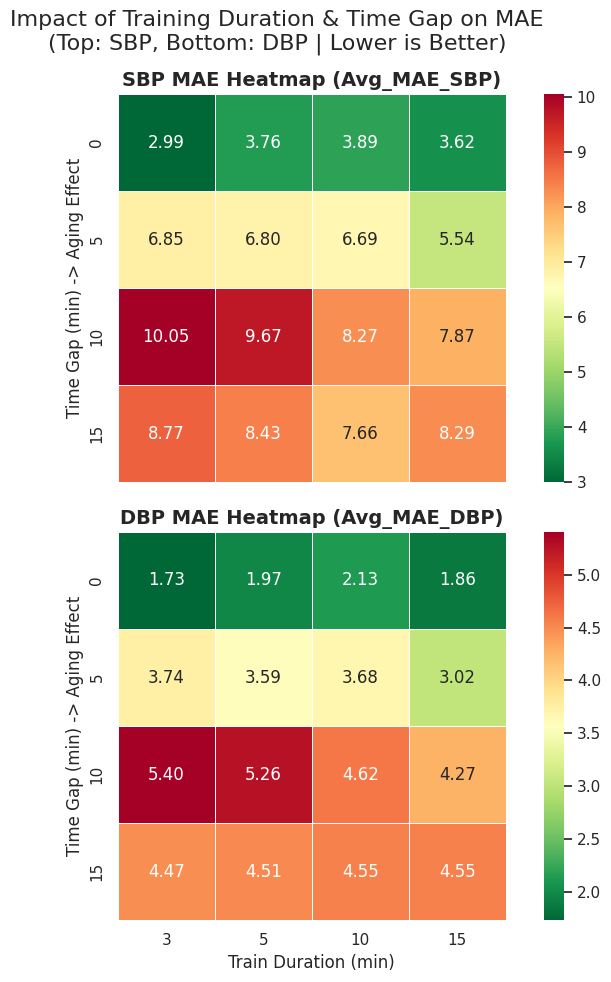

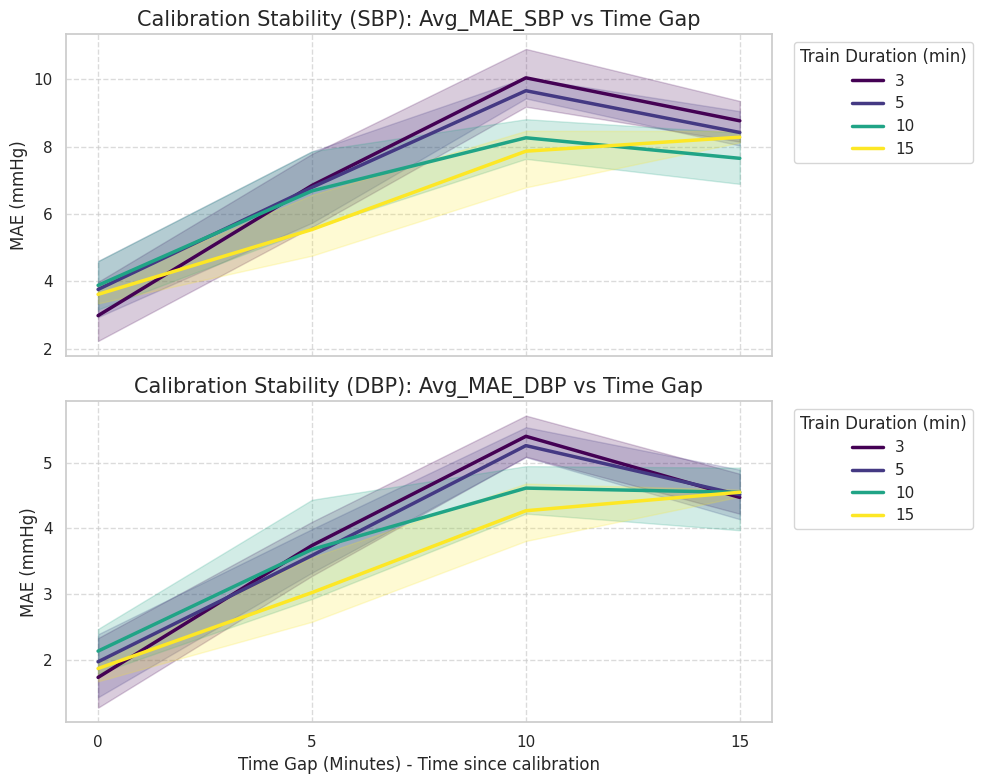

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = '/content/mimic_p043774_timegap_sweep_clean_ppgF_trainonlylabel_MAE_SD.csv'
df = pd.read_csv(file_path)

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 필요한 컬럼 체크
need_cols = {"TrainDur_min", "TimeGap_min", "Avg_MAE_SBP", "Avg_MAE_DBP"}
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# ============================================================
# [Plot 1] Heatmaps (2 rows):
#   Top: SBP  (Avg_MAE_SBP)
#   Bottom: DBP (Avg_MAE_DBP)
# ============================================================
df_avg = df.groupby(["TrainDur_min", "TimeGap_min"])[["Avg_MAE_SBP", "Avg_MAE_DBP"]].mean().reset_index()

sbp_vmin, sbp_vmax = df_avg["Avg_MAE_SBP"].min(), df_avg["Avg_MAE_SBP"].max()
dbp_vmin, dbp_vmax = df_avg["Avg_MAE_DBP"].min(), df_avg["Avg_MAE_DBP"].max()

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
fig.suptitle(
    "Impact of Training Duration & Time Gap on MAE\n(Top: SBP, Bottom: DBP | Lower is Better)",
    fontsize=16
)

# --- SBP heatmap
pivot_sbp = df_avg.pivot(index="TimeGap_min", columns="TrainDur_min", values="Avg_MAE_SBP")
sns.heatmap(
    pivot_sbp, annot=True, fmt=".2f", cmap="RdYlGn_r",
    ax=axes[0], vmin=sbp_vmin, vmax=sbp_vmax, cbar=True,
    linewidths=.5, square=True
)
axes[0].set_title("SBP MAE Heatmap (Avg_MAE_SBP)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Time Gap (min) -> Aging Effect", fontsize=12)
axes[0].set_xlabel("")

# --- DBP heatmap
pivot_dbp = df_avg.pivot(index="TimeGap_min", columns="TrainDur_min", values="Avg_MAE_DBP")
sns.heatmap(
    pivot_dbp, annot=True, fmt=".2f", cmap="RdYlGn_r",
    ax=axes[1], vmin=dbp_vmin, vmax=dbp_vmax, cbar=True,
    linewidths=.5, square=True
)
axes[1].set_title("DBP MAE Heatmap (Avg_MAE_DBP)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Time Gap (min) -> Aging Effect", fontsize=12)
axes[1].set_xlabel("Train Duration (min)", fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================
# [Plot 2] Calibration Stability (2 rows):
#   Top: SBP  (Avg_MAE_SBP)
#   Bottom: DBP (Avg_MAE_DBP)
# ============================================================
fig2, axes2 = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# SBP stability
sns.lineplot(
    data=df,
    x="TimeGap_min",
    y="Avg_MAE_SBP",
    hue="TrainDur_min",
    palette="viridis",
    markers=True,
    dashes=False,
    linewidth=2.5,
    ax=axes2[0]
)
axes2[0].set_title("Calibration Stability (SBP): Avg_MAE_SBP vs Time Gap", fontsize=15)
axes2[0].set_ylabel("MAE (mmHg)", fontsize=12)
axes2[0].grid(True, linestyle="--", alpha=0.7)
axes2[0].set_xticks([0, 5, 10, 15])
axes2[0].legend(title="Train Duration (min)", bbox_to_anchor=(1.02, 1), loc="upper left")

# DBP stability
sns.lineplot(
    data=df,
    x="TimeGap_min",
    y="Avg_MAE_DBP",
    hue="TrainDur_min",
    palette="viridis",
    markers=True,
    dashes=False,
    linewidth=2.5,
    ax=axes2[1]
)
axes2[1].set_title("Calibration Stability (DBP): Avg_MAE_DBP vs Time Gap", fontsize=15)
axes2[1].set_xlabel("Time Gap (Minutes) - Time since calibration", fontsize=12)
axes2[1].set_ylabel("MAE (mmHg)", fontsize=12)
axes2[1].grid(True, linestyle="--", alpha=0.7)
axes2[1].set_xticks([0, 5, 10, 15])
axes2[1].legend(title="Train Duration (min)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()
